# Opinion Shaping in Social Networks Using Reinforcement Learning

## Libs

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import time
import random
import math

from code_generation_graph import creation_graph, show_graph
from utils import Gamma, a, b, w, dw

## Graph Creation

```Some text to explain what we are doing```

### Simulation of the doc graph

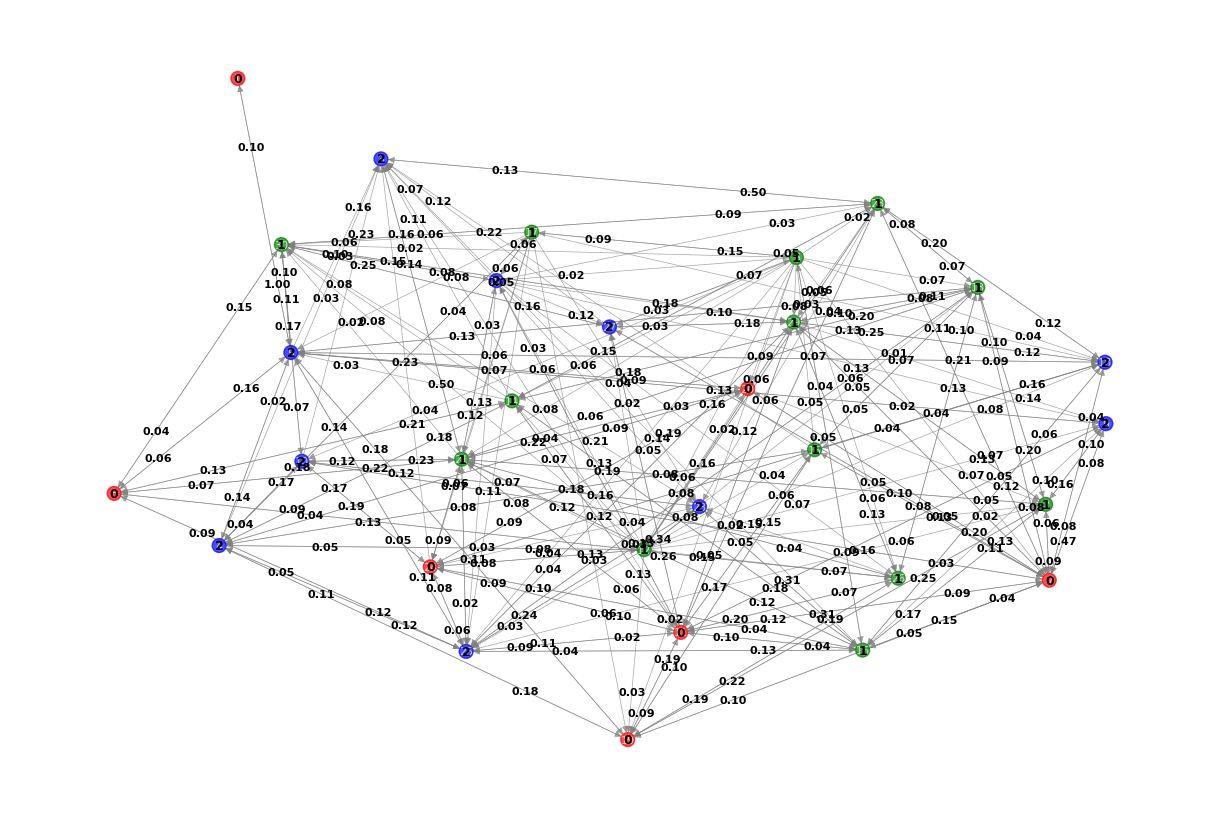

In [13]:
# first with a graph of size 10
Graph = creation_graph(30)
show_graph(Graph)

## Algorithms 

### Without knowledge of P: 

The first algorithm needs the full knowledge of P, which, in real life, means knowing how much everyone in the social network is susceptible to be influenced by everyone. 
This data is clearly impossible do find, even using surveys, as most people wouldn't be able to answer this question: how much each of your acquaintance can influence your opinion? 

To be able to compute the best solution of the algorithm without the knowledge of P, the hypotheis is that the planner can "observes" the communication between 2 agents when one polls another, thus understanding the impact of the polled agent on the first one.

The algorithm works as follows: 

At step k:

for each agent i in S and
for each agen j in S2, do the following:
$\Psi_{ij}(k+1) = \Psi_{ij}(k) + a(\nu(i,k))$


The cell below creates all necessary data to do the algorithm and to plot the graphs

In [33]:
n = Graph.number_of_nodes()
e = Graph.number_of_edges()

P = np.zeros((n,n)) 
#Although we don't need access to the whole matrix P,
# it is useful to compute it to observe the links between Z[k] and Z~[k], and to compare algorithms
for i,j,data  in Graph.edges.data():
    P[i-1,j-1] = data['weight']

S = {0:[],
     1:[],
     2:[]}

for i,data in Graph.nodes.data():
    S[data['status']].append(i)


alpha = np.zeros(n)
x = np.zeros(n)
u = np.zeros(n)
u[np.array(S[2])-1] = np.random.random(len(S[2]))
Max_iter = 10000
u_vec = np.zeros((Max_iter,n))
u_vec[0,:] = u
v = np.zeros(n)

Psi = np.random.random((n,n))
Psi[np.array(S[0])-1,:] = 0

Psi_vec = np.zeros((Max_iter,n,n))
Psi_vec[0,:,:] = Psi
Y = np.zeros(Max_iter,dtype = 'int')
Y[0] = random.choice(list(Graph.nodes.keys()))
v[Y[0]-1] += 1
B = 0.6
C = 100
A = 0.6
M = 5

In [34]:
for k in range(Max_iter-1):
    Y[k+1] = random.choices(list(Graph.nodes.keys()),weights = P[Y[k]-1,:])[0]
    if Y[k] in S[1]+S[2]:
        for i in S[1]+S[2]:
            for j in S[2]:
                Psi[i-1,j-1] += a(v[i-1],A,C)*(Y[k]==i)*((1-alpha[i-1])*Psi[Y[k+1]-1,j-1] - Psi[i-1,j-1])
                if i in S[2]:
                    Psi[i-1,j-1] += a(v[i-1],A,C)*(Y[k]==i)*alpha[i-1]*dw(u[i-1])*(i==j)
                    u[i-1] += b(k,B,C)*np.sum(Psi[:,i-1])
    u = Gamma(u,M,S[2])
    u_vec[k+1] = u
    Psi_vec[k+1] = Psi
    v[Y[k+1]-1] += 1


In [35]:
u2 = np.zeros(n)
u2[np.array(S[2])-1] = np.random.random(len(S[2]))
u_vec2 = np.zeros((Max_iter,n))
u_vec2[0,:] = u2
v2 = np.zeros(n)

Psi2 = np.random.random((n,n))
Psi2[np.array(S[0])-1,:] = 0

Psi_vec2 = np.zeros((Max_iter,n,n))
Psi_vec2[0,:,:] = Psi2

Z = np.zeros(Max_iter,dtype = 'int')
Z_tilde = np.zeros(Max_iter,dtype = 'int')

In [36]:
for k in range(Max_iter-1):
    Z[k] = random.choice(list(Graph.nodes.keys()))
    v2[Z[k]-1]+=1
    Z_tilde[k] = random.choices(list(Graph.nodes.keys()),weights = P[Z[k]-1,:])[0]
    if Z[k] in S[1]+S[2]:
        for i in S[1]+S[2]:
            for j in S[2]:
                Psi2[i-1,j-1] += a(v2[i-1],A,C)*(Z[k]==i)*((1-alpha[i-1])*Psi2[Z_tilde[k]-1,j-1] - Psi2[i-1,j-1])
                if i in S[2]:
                    Psi2[i-1,j-1] += a(v2[i-1],A,C)*(Z[k]==i)*alpha[i-1]*dw(u2[i-1])*(i==j)
                    u2[i-1] += b(k,B,C)*np.sum(Psi2[:,i-1])
    u2 = Gamma(u2,M,S[2])
    u_vec2[k+1] = u2
    Psi_vec2[k+1] = Psi2


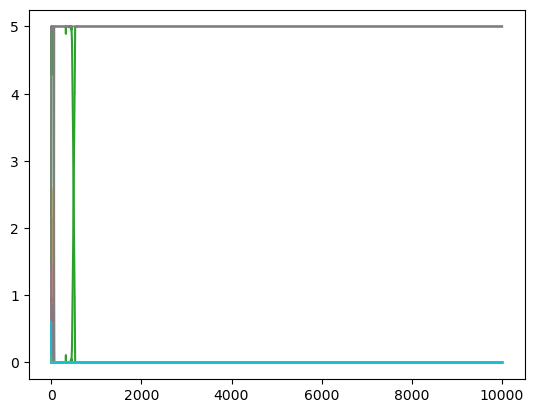

In [37]:
for i in S[2]:
    plt.plot(u_vec[:,i-1])
    plt.plot(u_vec2[:,i-1])